In [1]:
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib
import pandas as pd
import numpy as np
%matplotlib inline
import lightroot
from lightroot.detection import preprocessing
from lightroot.context import context
from lightroot.tracking import tpctree
c = context.folder_context("C:/Users/mrsir/Box Sync/CYCB-GFP/cut/April 4 (cut run 192)")

The directory ./cached_datax should be empty. Do you want to clear it? (y/n)n
17/07/2018 17:18:38 INFO:Setting a default value noise_trange:[0.01, 0.045]
17/07/2018 17:18:38 INFO:Setting a default value max_files:10000
17/07/2018 17:18:38 INFO:Setting a default value max_file_gap:100
17/07/2018 17:18:38 INFO:Setting a default value stack_file_format:C:/Users/mrsir/Box Sync/CYCB-GFP/cut/April 4 (cut run 192)\Run0192_tp{:0>3}.tif
17/07/2018 17:18:38 INFO:Data dir is set to C:/Users/mrsir/Box Sync/CYCB-GFP/cut/April 4 (cut run 192)
17/07/2018 17:18:38 INFO:Output dir is set to ./cached_datax
17/07/2018 17:18:38 INFO:Total_files:973
17/07/2018 17:18:38 INFO:Total_tiff_files:973
17/07/2018 17:18:38 INFO:Max_good_index:484
17/07/2018 17:18:38 INFO:First_good_index:0
17/07/2018 17:18:38 INFO:Frame_gaps:{}


# Sample Frames

17/07/2018 17:18:38 INFO:***********BEGIN PROCESSING LOOP***********
17/07/2018 17:18:38 INFO:loading settings file ./settings.json


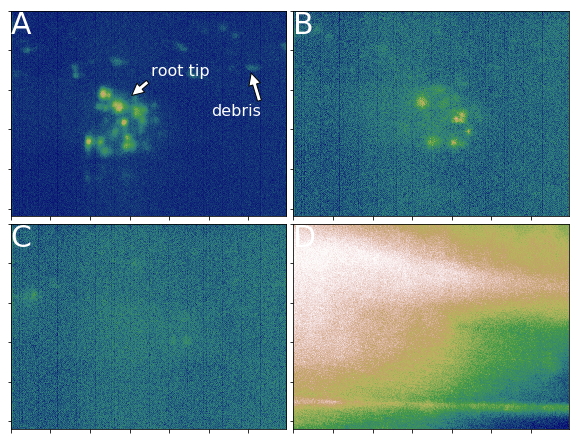

In [2]:
ims = [c.load_frame(i) for i in [0,45,81,99]]
F = lightroot.plots.plot_quad(ims)     
F.axes[0].annotate('root tip', color='white',xy=(120, 120), xytext=(140, 140),xycoords='axes pixels', fontsize=16,
            arrowprops=dict(facecolor='white', shrink=0.05))    
F.axes[0].annotate('debris', color='white',xy=(240, 145), xytext=(200, 100),xycoords='axes pixels', fontsize=16,
            arrowprops=dict(facecolor='white', shrink=0.05))    
F.savefig("./samples/sample_frames.pdf",bbox_inches='tight')

# ROI Stages

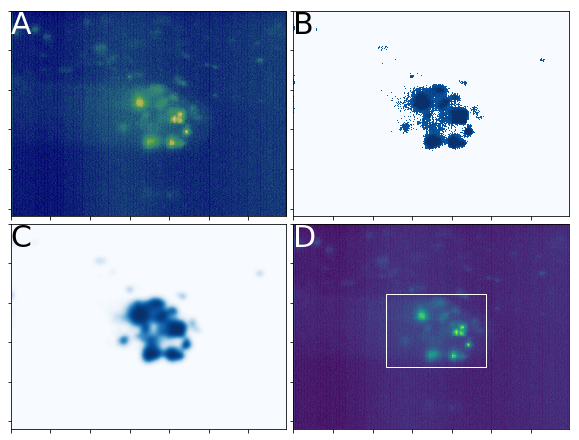

In [3]:
import matplotlib.patches as patches
def show_stages(c, i):    
    f0=c.load_frame(i)
    f1=preprocessing.denoise(f0,c)
    preprocessing.select_filtered_by_2d_lowband_largest_component(f1,c)#record the bounding box
    f2 = preprocessing.lowband_histogram_thresholding(f1.sum(0),c)
    f3 = preprocessing.smoothing(f2,c,props={"sigma":12})

    def cb (I,ax):
        inlay=0
        rect = c.bbox
        ax.imshow(I)
        ax.add_patch( patches.Rectangle(  list(reversed(rect[0:2])),   rect[3]-rect[1]-inlay,   rect[2]-rect[0]-inlay,  fill=False, edgecolor='white' ))

    return lightroot.plots.plot_quad([f1,f2,f3,f1], pals=["gist_earth", "Blues", "Blues", "gist_earth"], callbacks={3:cb}) 

res = show_stages(c,45)
F.savefig("./samples/roi_stages.pdf",bbox_inches='tight')

## load sample data...

In [4]:
frame_stats = pd.read_csv("./samples/test_stats390.csv")
frame_stats.head()
test_data = pd.read_csv("./samples/test_points.csv").drop("Unnamed: 0",1)

# Constellation sampling

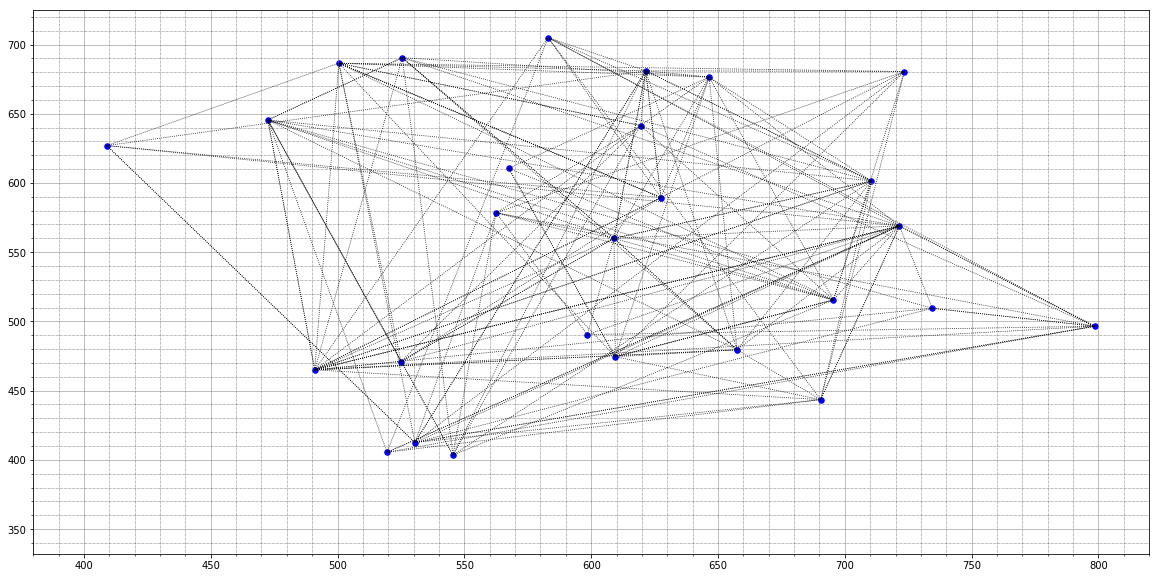

In [5]:
d1 = test_data[test_data.t==9].reset_index().drop("index",1)
d2 = test_data[test_data.t==10].reset_index().drop("index",1)
t = tpctree(d1)
t.update(test_data[test_data.t==10])
p = {"c":"b", "canvasx": [400,800,800,400],"canvasy": [700,700,350,350] }
cn = list(tpctree.constellation_sampler(d1,N=6))
_call=lightroot.utils.render_constellation_callback(cn)
cn = list(tpctree.constellation_sampler(d2,N=50))
_call=lightroot.utils.render_constellation_callback(cn)
ax= c._iom.plot(None, blob_overlay=d2, props=p,callback=_call)
plt.savefig("./samples/constellation_sample.pdf",bbox_inches='tight')

# Transform eval

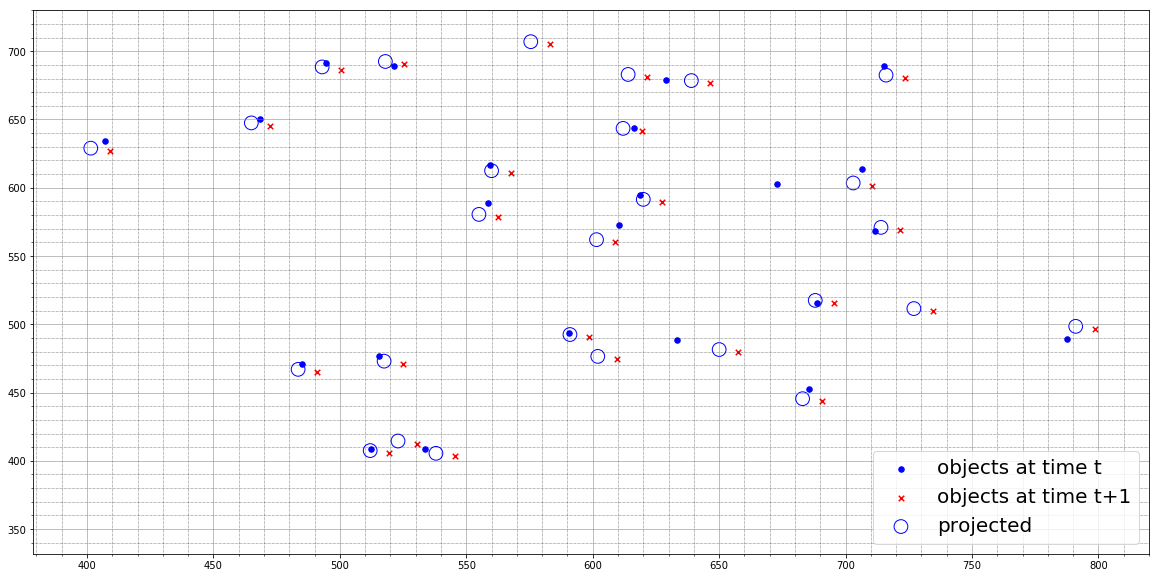

In [6]:
c._iom.plot(None, blob_overlay=d1,  props=p,callback=tpctree.show_projection_callback(d2, tr=t._last_transform))
plt.savefig("./samples/tr_eval.pdf",bbox_inches='tight')

# Life Matrix

In [7]:
lm = tpctree.make_life_matrix(pd.read_csv("./samples/test_tree_blobs.csv")).astype(int)
restricted = tpctree.make_life_matrix(pd.read_csv("./samples/test_tree_blobs.csv"),True).astype(int)
#_lm = lm# if we want to show all in time series plots
_lm = restricted
bandd = _lm.diff(1,axis=1,).fillna(0) #* lifetime_matrix
births = bandd[bandd==1].fillna(0)
deaths = np.abs(bandd[bandd==-1]).fillna(0)
ageMat = _lm.cumsum(axis=1) * _lm
lm.head()

,0,1,2,3,4,5,6,7,8,9,...,381,382,383,384,385,386,387,388,389,390
0.0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1.0,1,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2.0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3.0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4.0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


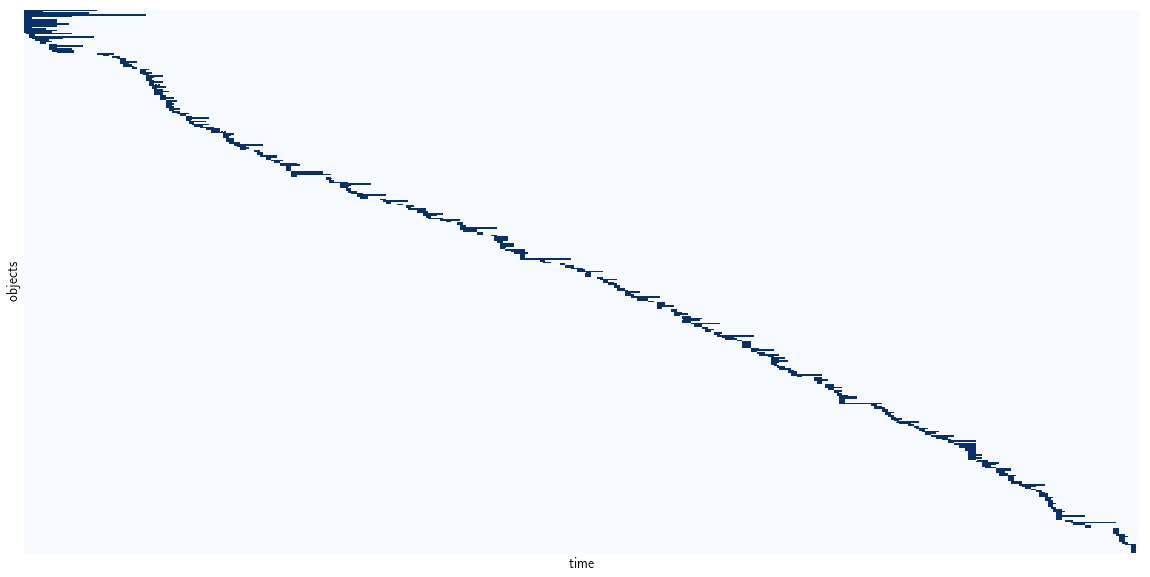

In [44]:
import seaborn as sns
fig = plt.figure(figsize=(20,10))
sns.heatmap(restricted.astype(int),cmap="Blues",cbar=False,yticklabels=False, xticklabels=False)
plt.ylabel("objects",fontsize=14)
plt.xlabel("time",fontsize=14)
#pdf = PdfPages("./samples/life_matrix.pdf")
#pdf.savefig(fig)
#pdf.close()
plt.savefig("./samples/life_matrix.png",bbox_inches='tight') #save as pdf takes some time - can save as png instead

# Time Series

In [ ]:
time = restricted.sum(axis=0).reset_index().drop("index",1)
time.columns = ["alive"]
time["births"] = births.sum()
time["deaths"] = deaths.sum()
time["observed_by_t"] = births.sum().cumsum().astype(int)
time["mean_age_at_t"]  = ageMat.replace(0, np.nan).mean(skipna=True).round(2).fillna(0)
time.index.name = 't'
time = time.reset_index()

temp = time

matplotlib.rcParams.update({'font.size': 12})
fig, (ax1, ax2) = plt.subplots(2,  figsize=(10,6), sharex=True)

ax1.plot(temp.index, temp.alive, '-')

ax1.set( ylabel='Number of objects')
ax1.yaxis.label.set_size(16)
ax1.yaxis.grid()
ax1.minorticks_on()
ax1.grid(b=True, which='minor', color='grey', linestyle='-', alpha=0.2)

ax2.plot(temp.index, temp.mean_age_at_t, '-')
ax2.set(ylabel='Mean age',)
ax2.yaxis.label.set_size(16)
ax2.xaxis.label.set_size(16)
ax2.yaxis.grid()

plt.subplots_adjust(hspace=0.1)
plt.xlim(0,200)
ax2.minorticks_on()
ax2.grid(b=True, which='minor', color='grey', linestyle='-', alpha=0.2)
fig.savefig("./samples/life_time_series.pdf",bbox_inches='tight')

In [ ]:
plt.figure(figsize=(10,5))
ah = pd.DataFrame(ageMat.max(axis=1),columns=["age_hist"])
ah['age_hist'].plot.hist(bins=40,ylim=(0,250)) 

In [ ]:
# ghj = frame_stats[["bbox_area"]][0:100]
# ghj["bounding box area"] = ghj["bbox_area"]/ghj["bbox_area"].max()
# ghj["1-frame detections"] = (lm.sum()-restricted.sum())/lm.sum()
# ax  =ghj[["bounding box area","1-frame detections"]].fillna(0).plot(figsize=(20,3),kind='area', stacked=False, alpha=0.3)
# #ax.figure.savefig("f8.pdf",bbox_inches='tight')

# Epsilon values

In [ ]:
# lms = []
# eps = [10,15,20,25,30,35,40,50,70]
# for epsilon in eps:
#     print("epsilon", epsilon)
#     data = pd.read_csv("./samples/test_tree_blobs.csv")
#     data = data[["t","x","y", "z"]]
#     tree=None
#     for g,d in data.groupby("t"):
#         print(".", end="")
#         if g %10 ==0:print()
#         if tree == None: tree = tpctree(d,options={"epsilon":epsilon})
#         else: tree.update(d) 
#         if g == 100:break
#     lms.append(tpctree.make_life_matrix(tree.data).astype(int))
# ghj = frame_stats[["bbox_area"]][0:100]
# ghj["bounding box area"] = ghj["bbox_area"]/ghj["bbox_area"].max()
# for i,_lm in enumerate(lms):
#     ghj["1-frame detections @ "+str(eps[i])] = (_lm.sum()-tpctree.get_restricted(_lm).sum())/_lm.sum()
# ghj.to_csv("./samples/epsilon_sfd_checks.csv")

In [ ]:
ghj = pd.read_csv("./samples/epsilon_sfd_checks.csv").drop("Unnamed: 0",1)
matplotlib.rc('text', usetex=True, fontsize=18)
totals = ghj.sum().reset_index()[2:].set_index(np.array(eps))
totals.columns = ["label", "single-frame detections for $\epsilon$ values"]
totals.index.name = "epsilon"
ax = totals[["single-frame detections for $\epsilon$ values"]].plot(style='--',figsize=(15,5))
ax.axvspan(20,25, alpha=0.1, color='blue')
pdf = PdfPages("./samples/epsilon_sfds.pdf")
pdf.savefig(fig)
pdf.close()
    
#ax.figure.savefig("./samples/epsilon_sfds.pdf",bbox_inches='tight')